This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Visualizing patterns

The [EBSD](reference.rst#kikuchipy.signals.EBSD) and
[EBSDMasterPattern](reference.rst#kikuchipy.signals.EBSDMasterPattern) signals
have a powerful and versatile
[plot()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.plot)
method provided by HyperSpy. Its uses are greatly detailed in HyperSpy's
[visualisation user guide](http://hyperspy.org/hyperspy-doc/current/user_guide/visualisation.html).
This section details example uses specific to EBSD and EBSDMasterPattern
signals.

Let's import the necessary libraries and a Nickel EBSD test data set
<cite data-cite="anes2019electron">Ånes et al. (2019)</cite>:

In [5]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import hyperspy.api as hs
import kikuchipy as kp
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import numpy as np
from orix import io, plot, quaternion, vector
import skimage.exposure as ske
import skimage.transform as skt


# Use kp.load("data.h5") to load your own data
s = kp.data.nickel_ebsd_large(allow_download=True)  # External download
s

<EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>

## Navigate in custom map

Correlating results from e.g. crystal and phase structure determination, i.e.
indexing, with experimental patterns can inform their interpretation. When
calling `plot()` without any input parameters, the navigator map is a grey scale
image with pixel values corresponding to the sum of all detector intensities
within that pattern:

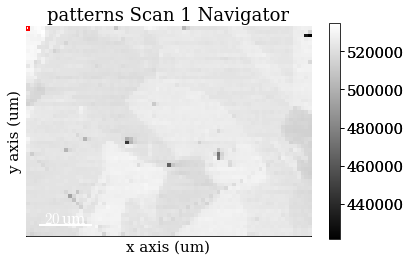

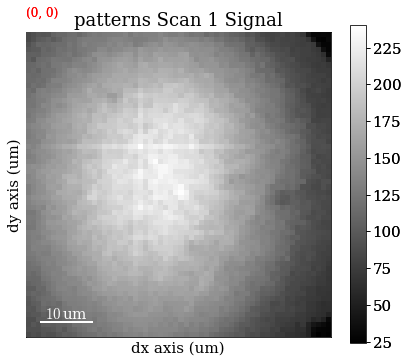

In [6]:
s.plot()

The upper panel shows the navigation axes, in this case 2D, with the current
beam position in the upper left corner shown as a red square the size of one
pixel. This square can be made larger/smaller with <kbd>+</kbd>/<kbd>-</kbd>.
The square can be moved either by the keyboard arrows or the mouse. The lower
panel shows the image on the detector in the current beam position.

Any
[BaseSignal](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal)
signal with a 2D `signal_shape` corresponding to the scan
`navigation_shape` can be passed in to the `navgiator` parameter in
[plot()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.plot),
including a virtual image showing diffraction contrast, any quality metric map,
or an orientation map or a phase map.

## Virtual image

A virtual backscatter electron (VBSE) image created from any detector region of
interest with the
[get_virtual_bse_intensity()](reference.rst#kikuchipy.signals.EBSD.get_virtual_bse_intensity)
method or
[get_rgb_image()](reference.rst#kikuchipy.generators.VirtualBSEGenerator.get_rgb_image)
explained in the
[virtual backscatter electron imaging](virtual_backscatter_electron_imaging.rst)
section, can be used as a navigator for a scan `s`:

In [7]:
vbse_gen = kp.generators.VirtualBSEGenerator(s)
print(vbse_gen)
print(vbse_gen.grid_shape)

VirtualBSEGenerator for <EBSD, title: patterns Scan 1, dimensions: (75, 55|60, 60)>
(5, 5)


In [8]:
vbse_rgb = vbse_gen.get_rgb_image(r=(3, 1), b=(3, 2), g=(3, 3))
vbse_rgb

<VirtualBSEImage, title: , dimensions: (|75, 55)>

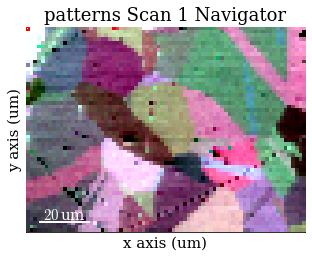

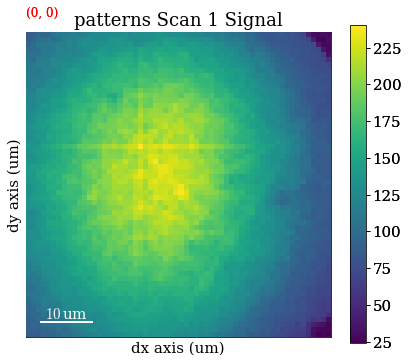

In [9]:
s.plot(navigator=vbse_rgb, cmap="viridis")

## Any image

Images loaded into a
[Signal2D](http://hyperspy.org/hyperspy-doc/current/api/hyperspy._signals.signal2d.html#hyperspy._signals.signal2d.Signal2D)
can be used as navigators, like a quality metric map like the
[image quality map](feature_maps.ipynb#Image-quality) calculated using
[get_image_quality()](reference.rst#kikuchipy.signals.EBSD.get_image_quality):

In [10]:
s.remove_static_background()
s.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.5s
Removing the dynamic background:
[########################################] | 100% Completed |  1.4s


Calculating the image quality:
[########################################] | 100% Completed |  1.2s


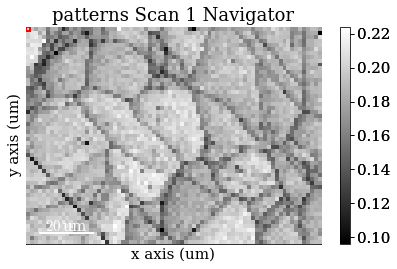

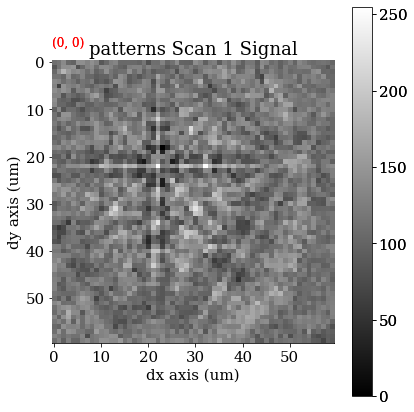

In [11]:
iq = s.get_image_quality()
s_iq = hs.signals.Signal2D(iq)
s.plot(navigator=s_iq, scalebar=False)

Using colour images (apart from creating RGB virtual BSE images, as shown
above), e.g. an orientation map, `om`, or phase map, is a bit more involved
(especially when the image doesn't have the correct pixel shape, as is the case
for our orientation map below, exported from MTEX):

In [12]:
om = plt.imread('_static/image/visualizing_patterns/om.png')
print(om.shape, om.dtype)
om_resized = skt.resize(
    om,
    output_shape=s.axes_manager.navigation_shape[::-1] + (3,),
    anti_aliasing=False
)
om_scaled = ske.rescale_intensity(om_resized, out_range=np.uint8)
s_om = hs.signals.Signal2D(om_scaled)
s_om

(764, 1036, 3) float32


<Signal2D, title: , dimensions: (55|3, 75)>

In [13]:
s_om = s_om.transpose(signal_axes=1)
print(s_om, s_om.data.dtype)

<Signal1D, title: , dimensions: (75, 55|3)> uint8


In [14]:
s_om.change_dtype('rgb8')
print(s_om, s_om.data.dtype)

<Signal2D, title: , dimensions: (|75, 55)> [('R', 'u1'), ('G', 'u1'), ('B', 'u1')]


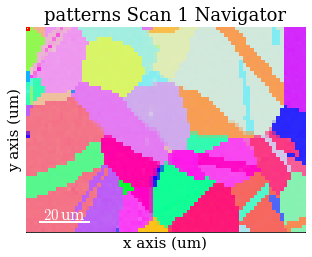

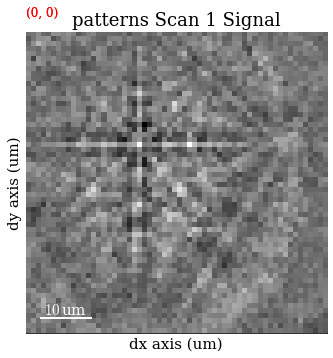

In [15]:
s.plot(navigator=s_om, colorbar=False)

## Plot multiple signals

HyperSpy provides the function
[plot_signals()](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.drawing.utils.html#hyperspy.drawing.utils.plot_signals)
to plot multiple signals with the same navigator, as explained in their
[user guide](http://hyperspy.org/hyperspy-doc/current/user_guide/visualisation.html#plotting-several-signals).
This enables e.g. plotting of experimental and best matching simulated patterns
side-by-side as a visual inspection of the results of
[pattern matching](pattern_matching.ipynb). To demonstrate this, we'll load
a [CrystalMap](https://orix.readthedocs.io/en/stable/reference.html#crystalmap)
with the best matching orientations of dynamically simulated Ni patterns to
Nickel test data set, and project these patterns onto our detector from a master
pattern

In [24]:
xmap = io.load("_static/data/ni_large.h5")
xmap

Phase  Orientations  Name  Space group  Point group  Proper point group     Color
    0  4125 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

In [17]:
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert")

In [18]:
s_best = mp.get_patterns(
    rotations=xmap.rotations,
    detector=kp.detectors.EBSDDetector(
        shape=s.axes_manager.signal_shape[::-1],
        pc=[0.421, 0.7794, 0.5049],
        sample_tilt=70,
        convention="tsl"
    ),
    energy=20,
    dtype_out=s.data.dtype,
    compute=True
)
s_best = kp.signals.EBSD(s_best.data.reshape(s.data.shape))

Let's create a navigator map from the normalized cross-correlation scores

In [19]:
ncc = xmap.get_map_data(xmap.scores[:, 0])
s_ncc = hs.signals.Signal2D(ncc)

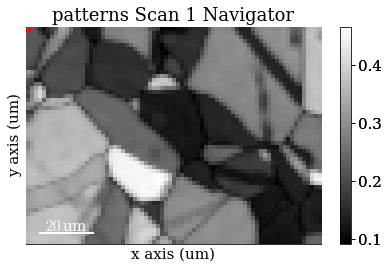

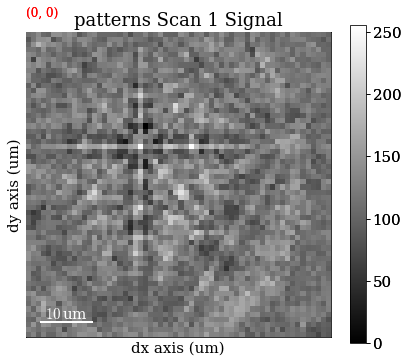

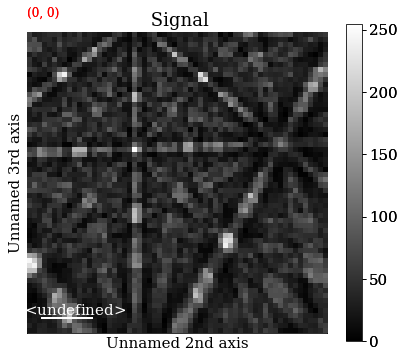

In [20]:
hs.plot.plot_signals([s, s_best], navigator=s_ncc)

We've made GIF to show this interactive plotting in action

<img src="_static/image/visualizing_patterns/plot_multiple_scans.gif"/>

## Plot master patterns

[EBSDMasterPattern](reference.rst#kikuchipy.signals.EBSDMasterPattern) signals
can be navigated along their energy axis and/or the their northern/southern
hemisphere. Let's reload the Nickel master pattern used in the previous section,
but this time in the stereographic projection.

In [21]:
# Only a single energy, 20 keV
mp_stereo = kp.data.nickel_ebsd_master_pattern_small(    projection="spherical", hemisphere="both")
mp_stereo.axes_manager

<Axes manager, axes: (2|401, 401)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               y |      2 |      0 |       0 |       1 | hemisphere 
---------------- | ------ | ------ | ------- | ------- | ------ 
           width |    401 |        |  -2e+02 |       1 |     px 
          height |    401 |        |  -2e+02 |       1 |     px

As can be seen from the axes manager, the master pattern has two navigation
axes, a north and south hemisphere, thus, when plotting, we get a slider as a
navigator when plotting:

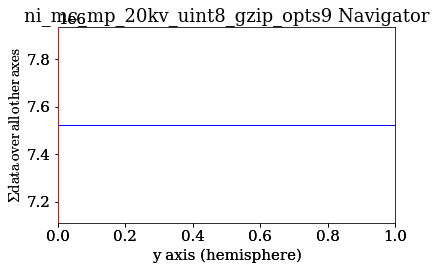

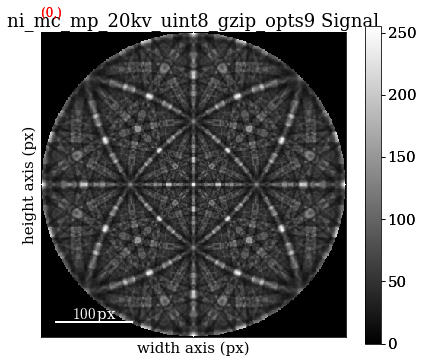

In [22]:
mp_stereo.plot()